In [92]:
from prophet import Prophet
import itertools
import math
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# Defining training and test
training_upto = 2021
forecast_upto = (2023-training_upto-1)*12 +3

In [4]:
# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Prediction Whole of Barnet

In [4]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
monthly_grouped_df['covid']  = 0
monthly_grouped_df['covid'][((monthly_grouped_df['year']==2020) & (monthly_grouped_df['month']>2)) | ((monthly_grouped_df['year']==2021)& (monthly_grouped_df['month']<6))]

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

### Hyper-parameter tuning

In [11]:
# Defining the parameters & values to be tuned
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.5, 0.1, 1,0.01],
    'seasonality_prior_scale': [0.5, 0.1, 1, 0.01],
    'holidays_prior_scale':[1, 10, 25, 50],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

14:02:10 - cmdstanpy - INFO - Chain [1] start processing
14:02:10 - cmdstanpy - INFO - Chain [1] done processing
14:02:38 - cmdstanpy - INFO - Chain [1] start processing
14:02:38 - cmdstanpy - INFO - Chain [1] done processing
14:03:03 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing
14:03:26 - cmdstanpy - INFO - Chain [1] start processing
14:03:26 - cmdstanpy - INFO - Chain [1] done processing
14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing
14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing
14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:09 - cmdstanpy - INFO - Chain [1]

Mean absolute error:  59
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 50}


16:45:10 - cmdstanpy - INFO - Chain [1] start processing
16:45:10 - cmdstanpy - INFO - Chain [1] done processing


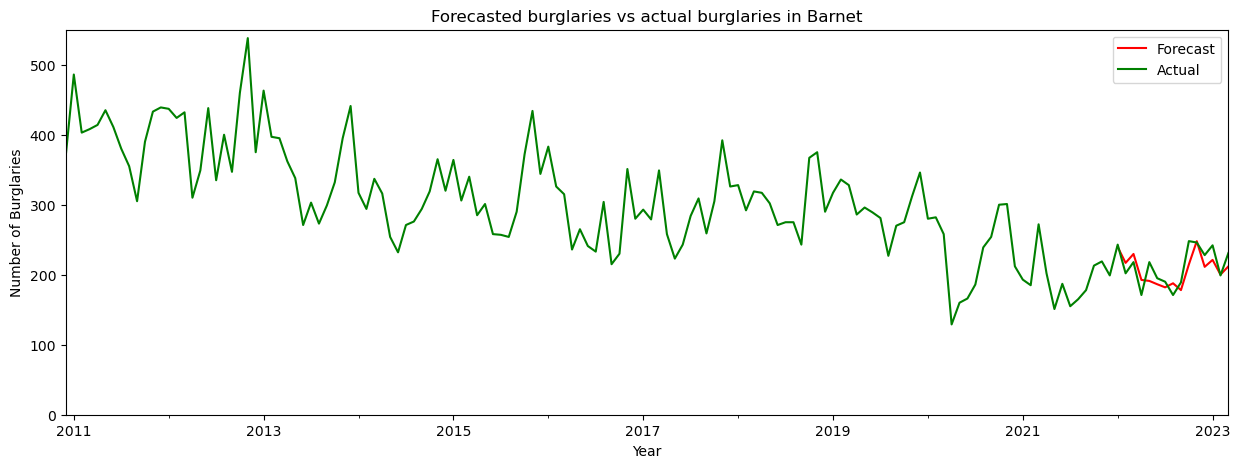

MAE 14.379002243731367
MSE 285.9073727833348
R2 0.5679823317288297


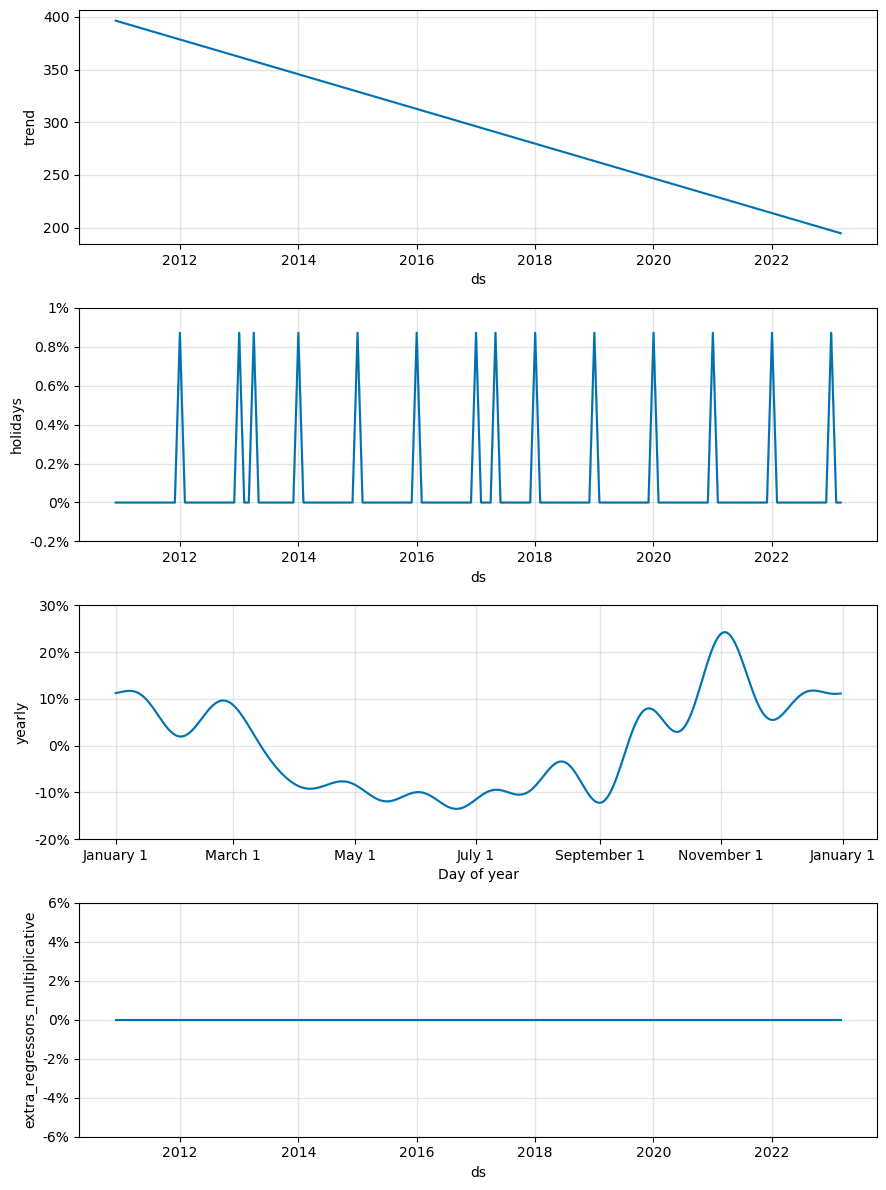

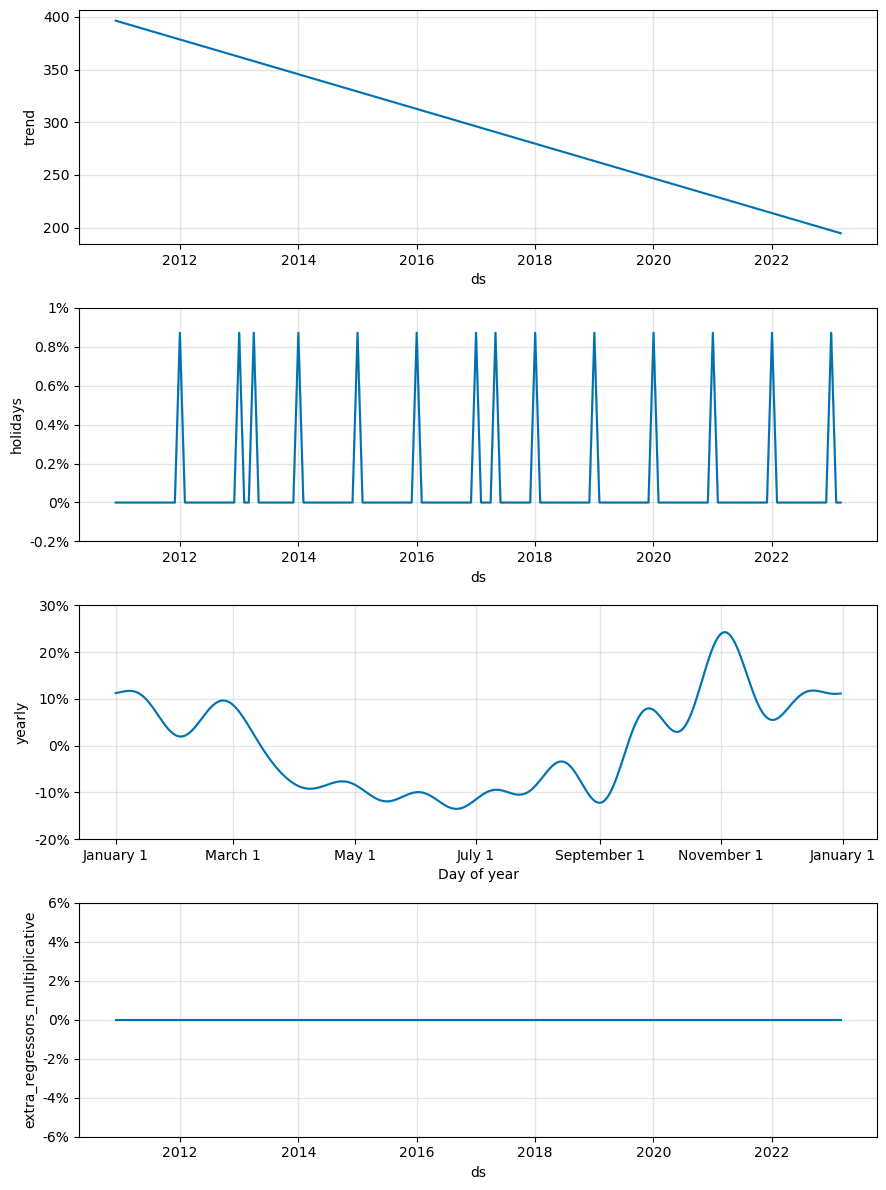

In [20]:
# Train the model with the best parameters and forecast
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 1, holidays_prior_scale= 50, holidays= holiday)
best_model.add_regressor('covid')
best_model.fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
future_dates['covid'] = 0
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries in Barnet')
plt.xlabel("Year")
plt.ylabel("Number of Burglaries")
plt.ylim(0,550)
plt.show()

print("MAE", mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("MSE", mean_squared_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("R2", r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))

best_model.plot_components(forecast)

## Prediction per ward

In [102]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')
populations = file[['Population per square kilometre', 'Month num', 'Year', 'Ward']].rename(columns = {'Month num': 'month', 'Year': 'year'}).drop_duplicates()
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num'])['Crime ID'].count()
df_per_ward = df_per_ward.reset_index()


 # Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()


# # Specify columns: ds, y, Date, covid
df_per_ward['day'] = 1
df_per_ward = df_per_ward.rename(columns = {"Crime ID":"y", 'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['covid']  = 0
df_per_ward['covid'][((df_per_ward['year']==2020) & (df_per_ward['month']>2)) | ((df_per_ward['year']==2021)& (df_per_ward['month']<6))] = 1
dates['Date'] = dates[0]
dates = dates[['Date']]

df_per_ward = df_per_ward.merge(populations, on = ['month','year', 'Ward'], how = 'left')

df_per_ward['covid'].isnull().sum()

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\2327463399.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0

24
            ds       Date  year  y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  0                              NaN      0
1   2011-01-01 2011-01-01  2011  0                              NaN      0
2   2011-02-01 2011-02-01  2011  0                              NaN      0
3   2011-03-01 2011-03-01  2011  0                              NaN      0
4   2011-04-01 2011-04-01  2011  0                              NaN      0
..         ...        ...   ... ..                              ...    ...
143 2022-11-01 2022-11-01  2022  5                              NaN      0
144 2022-12-01 2022-12-01  2022  7                              NaN      0
145 2023-01-01 2023-01-01  2023  4                              NaN      0
146 2023-02-01 2023-02-01  2023  2                              NaN      0
147 2023-03-01 2023-03-01  2023  5                              NaN      0

[148 rows x 6 columns]
nan
          Date         ds  year  y  Population per square kilometre  

17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing


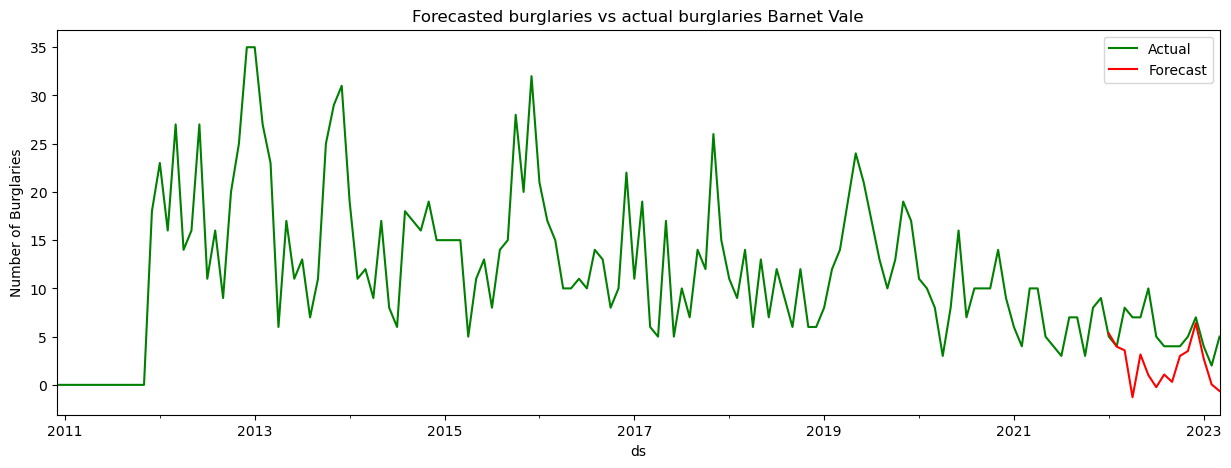

            ds       Date  year   y  Population per square kilometre  covid
148 2010-12-01 2010-12-01  2010   0                              NaN      0
149 2011-01-01 2011-01-01  2011   0                      5183.994959      0
150 2011-02-01 2011-02-01  2011   0                      5183.994959      0
151 2011-03-01 2011-03-01  2011   0                      5183.994959      0
152 2011-04-01 2011-04-01  2011   0                      5183.994959      0
..         ...        ...   ...  ..                              ...    ...
291 2022-11-01 2022-11-01  2022   4                      5288.909893      0
292 2022-12-01 2022-12-01  2022   4                      5288.909893      0
293 2023-01-01 2023-01-01  2023   6                      5278.512917      0
294 2023-02-01 2023-02-01  2023  14                      5278.512917      0
295 2023-03-01 2023-03-01  2023  13                      5278.512917      0

[148 rows x 6 columns]
5278.024253179533
          Date         ds  year   y  Populatio

17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing


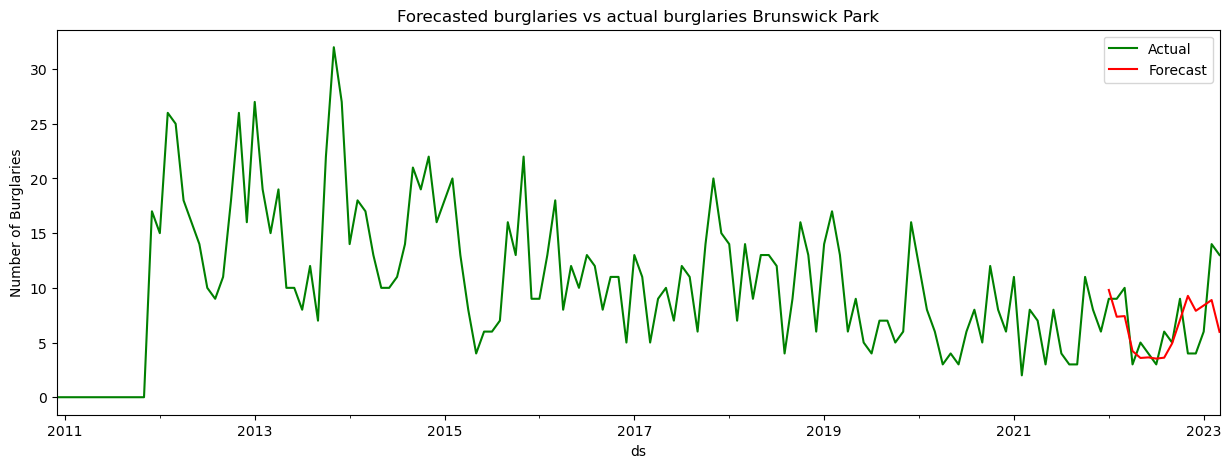

            ds       Date  year   y  Population per square kilometre  covid
296 2010-12-01 2010-12-01  2010   0                              NaN      0
297 2011-01-01 2011-01-01  2011   0                      8856.104651      0
298 2011-02-01 2011-02-01  2011   0                      8856.104651      0
299 2011-03-01 2011-03-01  2011   0                      8856.104651      0
300 2011-04-01 2011-04-01  2011   0                      8856.104651      0
..         ...        ...   ...  ..                              ...    ...
439 2022-11-01 2022-11-01  2022  15                      9787.790698      0
440 2022-12-01 2022-12-01  2022  14                      9787.790698      0
441 2023-01-01 2023-01-01  2023  11                      9746.608527      0
442 2023-02-01 2023-02-01  2023   5                      9746.608527      0
443 2023-03-01 2023-03-01  2023  11                      9746.608527      0

[148 rows x 6 columns]
9561.788087327954
          Date         ds  year   y  Populatio

17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing


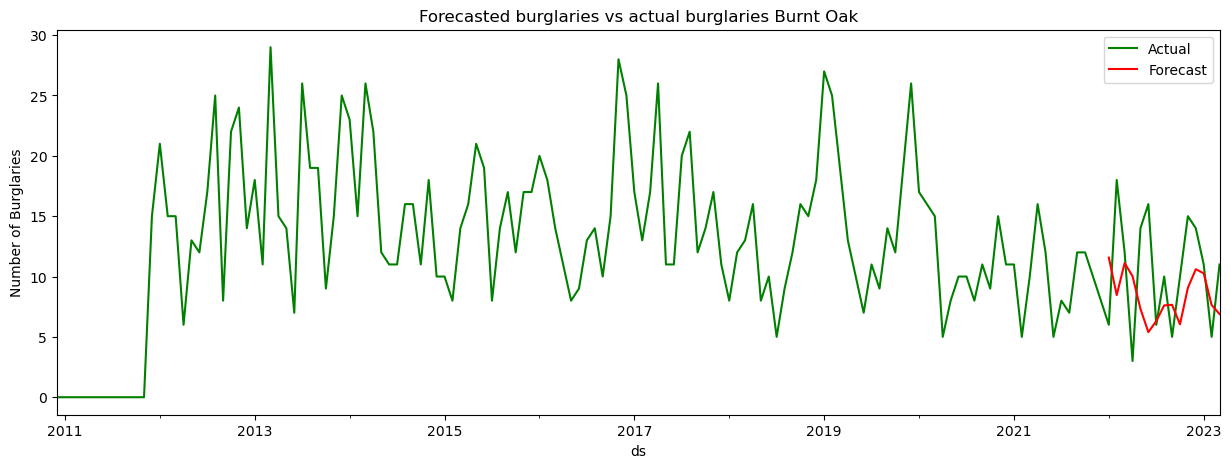

            ds       Date  year   y  Population per square kilometre  covid
444 2010-12-01 2010-12-01  2010   0                              NaN      0
445 2011-01-01 2011-01-01  2011   0                      6510.844934      0
446 2011-02-01 2011-02-01  2011   0                      6510.844934      0
447 2011-03-01 2011-03-01  2011   0                      6510.844934      0
448 2011-04-01 2011-04-01  2011   0                      6510.844934      0
..         ...        ...   ...  ..                              ...    ...
587 2022-11-01 2022-11-01  2022  31                      7399.805762      0
588 2022-12-01 2022-12-01  2022  21                      7399.805762      0
589 2023-01-01 2023-01-01  2023  22                      7400.129492      0
590 2023-02-01 2023-02-01  2023  21                      7400.129492      0
591 2023-03-01 2023-03-01  2023  19                      7400.129492      0

[148 rows x 6 columns]
7068.313502157094
          Date         ds  year   y  Populatio

17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing


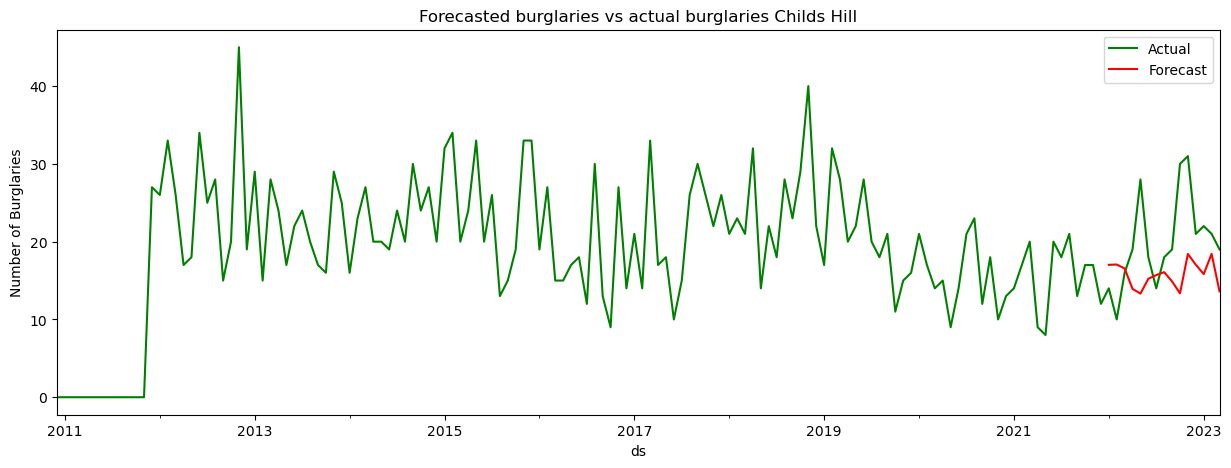

            ds       Date  year   y  Population per square kilometre  covid
592 2010-12-01 2010-12-01  2010   0                              NaN      0
593 2011-01-01 2011-01-01  2011   0                              NaN      0
594 2011-02-01 2011-02-01  2011   0                              NaN      0
595 2011-03-01 2011-03-01  2011   0                              NaN      0
596 2011-04-01 2011-04-01  2011   0                              NaN      0
..         ...        ...   ...  ..                              ...    ...
735 2022-11-01 2022-11-01  2022   6                              NaN      0
736 2022-12-01 2022-12-01  2022   6                              NaN      0
737 2023-01-01 2023-01-01  2023   8                              NaN      0
738 2023-02-01 2023-02-01  2023   4                              NaN      0
739 2023-03-01 2023-03-01  2023  12                              NaN      0

[148 rows x 6 columns]
nan
          Date         ds  year   y  Population per square k

17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing


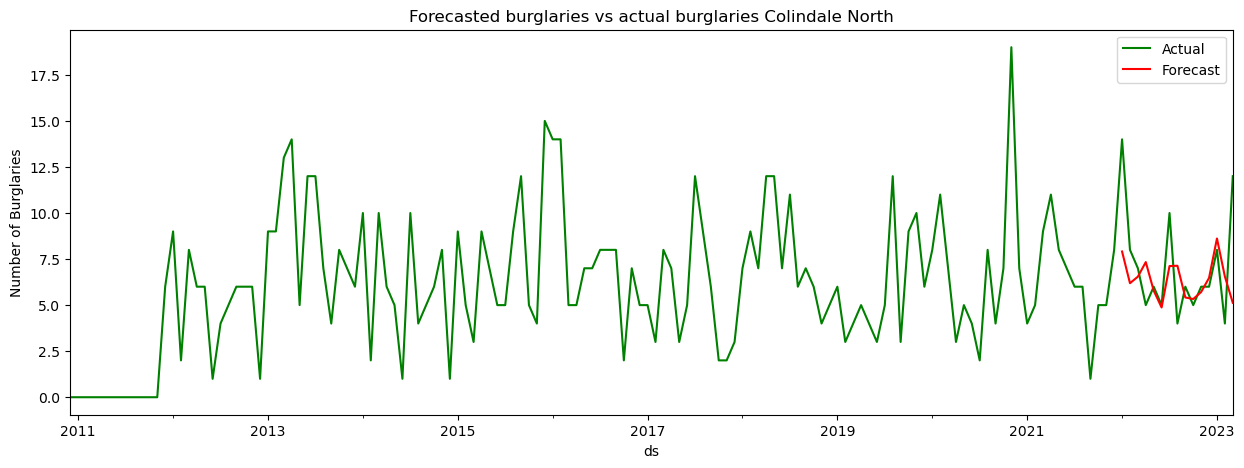

            ds       Date  year   y  Population per square kilometre  covid
740 2010-12-01 2010-12-01  2010   0                              NaN      0
741 2011-01-01 2011-01-01  2011   0                              NaN      0
742 2011-02-01 2011-02-01  2011   0                              NaN      0
743 2011-03-01 2011-03-01  2011   0                              NaN      0
744 2011-04-01 2011-04-01  2011   0                              NaN      0
..         ...        ...   ...  ..                              ...    ...
882 2022-11-01 2022-11-01  2022   4                              NaN      0
883 2022-12-01 2022-12-01  2022  10                              NaN      0
884 2023-01-01 2023-01-01  2023  12                              NaN      0
885 2023-02-01 2023-02-01  2023   9                              NaN      0
886 2023-03-01 2023-03-01  2023   6                              NaN      0

[147 rows x 6 columns]
nan
          Date         ds    year     y  Population per squa

17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing


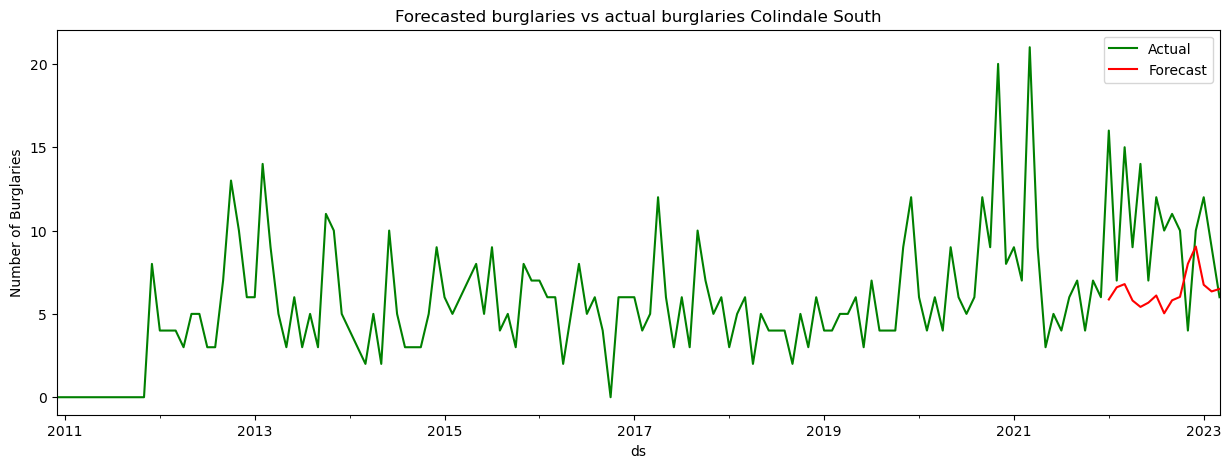

             ds       Date  year   y  Population per square kilometre  covid
887  2010-12-01 2010-12-01  2010   0                              NaN      0
888  2011-01-01 2011-01-01  2011   0                              NaN      0
889  2011-02-01 2011-02-01  2011   0                              NaN      0
890  2011-03-01 2011-03-01  2011   0                              NaN      0
891  2011-04-01 2011-04-01  2011   0                              NaN      0
...         ...        ...   ...  ..                              ...    ...
1030 2022-11-01 2022-11-01  2022  17                              NaN      0
1031 2022-12-01 2022-12-01  2022  12                              NaN      0
1032 2023-01-01 2023-01-01  2023  12                              NaN      0
1033 2023-02-01 2023-02-01  2023  15                              NaN      0
1034 2023-03-01 2023-03-01  2023   9                              NaN      0

[148 rows x 6 columns]
nan
          Date         ds  year   y  Population 

17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing


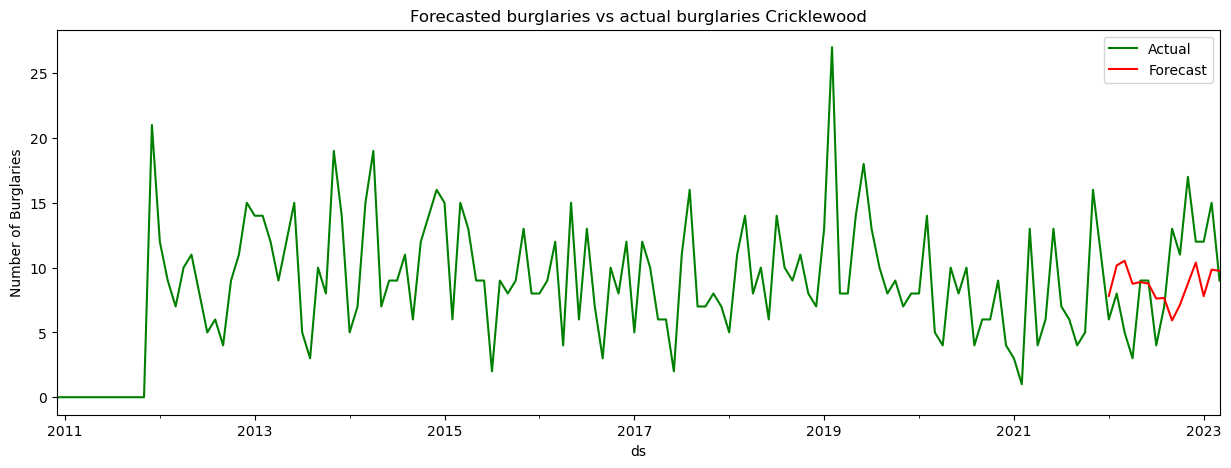

             ds       Date  year   y  Population per square kilometre  covid
1035 2010-12-01 2010-12-01  2010   0                              NaN      0
1036 2011-01-01 2011-01-01  2011   0                      4316.364606      0
1037 2011-02-01 2011-02-01  2011   0                      4316.364606      0
1038 2011-03-01 2011-03-01  2011   0                      4316.364606      0
1039 2011-04-01 2011-04-01  2011   0                      4316.364606      0
...         ...        ...   ...  ..                              ...    ...
1178 2022-11-01 2022-11-01  2022   5                      4736.407249      0
1179 2022-12-01 2022-12-01  2022  12                      4736.407249      0
1180 2023-01-01 2023-01-01  2023   9                      4793.443497      0
1181 2023-02-01 2023-02-01  2023   5                      4793.443497      0
1182 2023-03-01 2023-03-01  2023   8                      4793.443497      0

[148 rows x 6 columns]
4509.796135938384
          Date         ds  year   

17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing


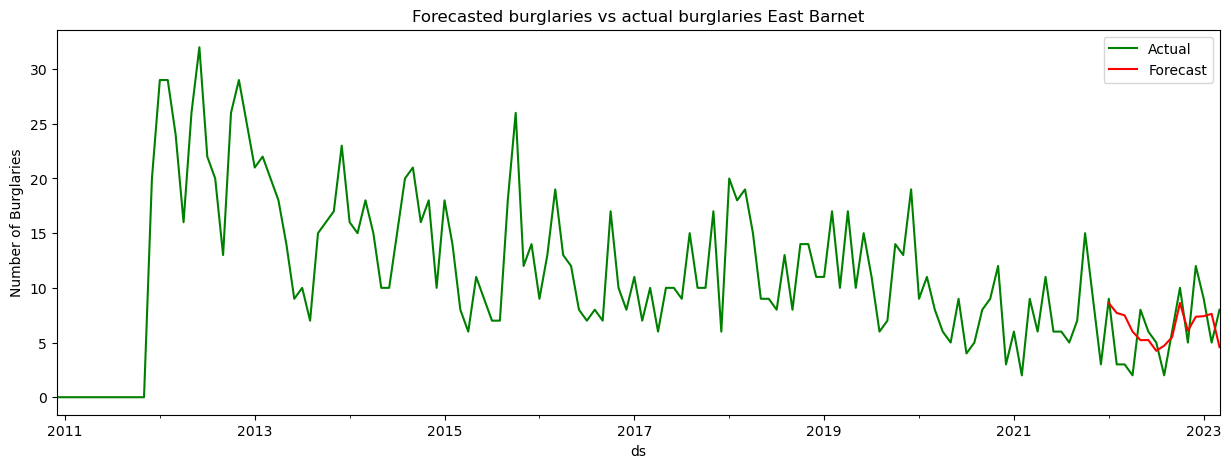

             ds       Date  year  y  Population per square kilometre  covid
1183 2010-12-01 2010-12-01  2010  0                              NaN      0
1184 2011-01-01 2011-01-01  2011  0                      6358.954041      0
1185 2011-02-01 2011-02-01  2011  0                      6358.954041      0
1186 2011-03-01 2011-03-01  2011  0                      6358.954041      0
1187 2011-04-01 2011-04-01  2011  0                      6358.954041      0
...         ...        ...   ... ..                              ...    ...
1326 2022-11-01 2022-11-01  2022  3                      6841.521395      0
1327 2022-12-01 2022-12-01  2022  6                      6841.521395      0
1328 2023-01-01 2023-01-01  2023  4                      6799.920761      0
1329 2023-02-01 2023-02-01  2023  5                      6799.920761      0
1330 2023-03-01 2023-03-01  2023  9                      6799.920761      0

[148 rows x 6 columns]
6740.4104272453815
          Date         ds  year  y  Populatio

17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing


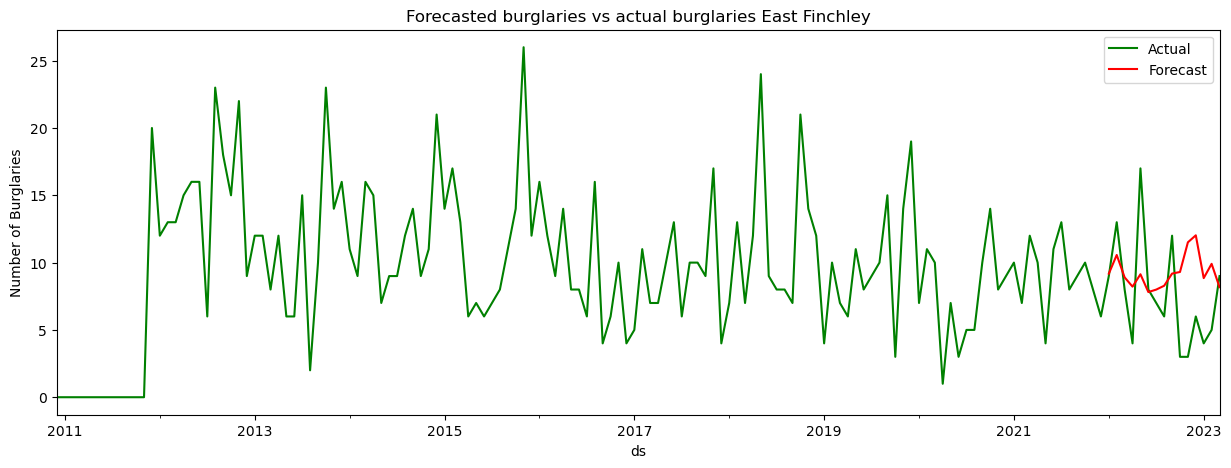

             ds       Date  year   y  Population per square kilometre  covid
1331 2010-12-01 2010-12-01  2010   0                              NaN      0
1332 2011-01-01 2011-01-01  2011   0                      3019.244604      0
1333 2011-02-01 2011-02-01  2011   0                      3019.244604      0
1334 2011-03-01 2011-03-01  2011   0                      3019.244604      0
1335 2011-04-01 2011-04-01  2011   0                      3019.244604      0
...         ...        ...   ...  ..                              ...    ...
1474 2022-11-01 2022-11-01  2022   9                      3883.273381      0
1475 2022-12-01 2022-12-01  2022  11                      3883.273381      0
1476 2023-01-01 2023-01-01  2023  11                      3928.417266      0
1477 2023-02-01 2023-02-01  2023  11                      3928.417266      0
1478 2023-03-01 2023-03-01  2023  11                      3928.417266      0

[148 rows x 6 columns]
3503.2667743356333
          Date         ds  year  

17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing


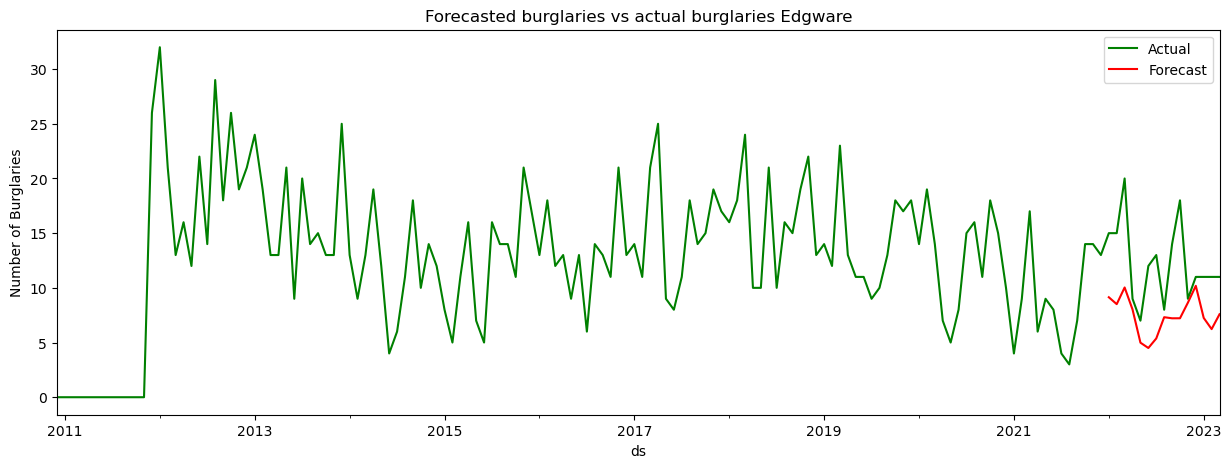

             ds       Date  year  y  Population per square kilometre  covid
1479 2010-12-01 2010-12-01  2010  0                              NaN      0
1480 2011-01-01 2011-01-01  2011  0                              NaN      0
1481 2011-02-01 2011-02-01  2011  0                              NaN      0
1482 2011-03-01 2011-03-01  2011  0                              NaN      0
1483 2011-04-01 2011-04-01  2011  0                              NaN      0
...         ...        ...   ... ..                              ...    ...
1619 2022-11-01 2022-11-01  2022  5                              NaN      0
1620 2022-12-01 2022-12-01  2022  5                              NaN      0
1621 2023-01-01 2023-01-01  2023  2                              NaN      0
1622 2023-02-01 2023-02-01  2023  4                              NaN      0
1623 2023-03-01 2023-03-01  2023  5                              NaN      0

[145 rows x 6 columns]
nan
          Date         ds    year    y  Population per squar

17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing


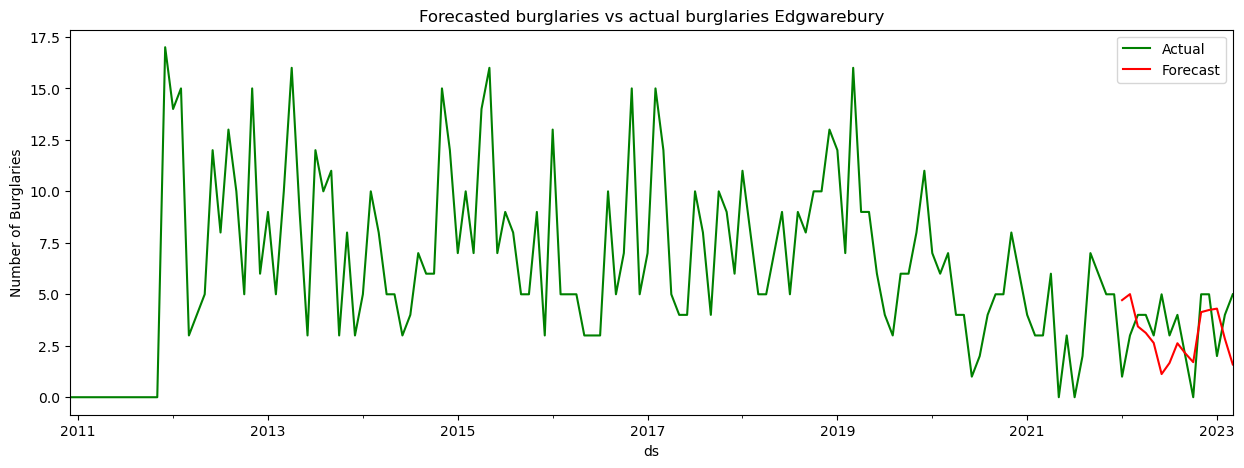

             ds       Date  year   y  Population per square kilometre  covid
1624 2010-12-01 2010-12-01  2010   0                              NaN      0
1625 2011-01-01 2011-01-01  2011   0                      5824.289406      0
1626 2011-02-01 2011-02-01  2011   0                      5824.289406      0
1627 2011-03-01 2011-03-01  2011   0                      5824.289406      0
1628 2011-04-01 2011-04-01  2011   0                      5824.289406      0
...         ...        ...   ...  ..                              ...    ...
1767 2022-11-01 2022-11-01  2022   9                      6310.446659      0
1768 2022-12-01 2022-12-01  2022  16                      6310.446659      0
1769 2023-01-01 2023-01-01  2023  11                      6295.681063      0
1770 2023-02-01 2023-02-01  2023  17                      6295.681063      0
1771 2023-03-01 2023-03-01  2023  18                      6295.681063      0

[148 rows x 6 columns]
6148.959251474678
          Date         ds  year   

17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing


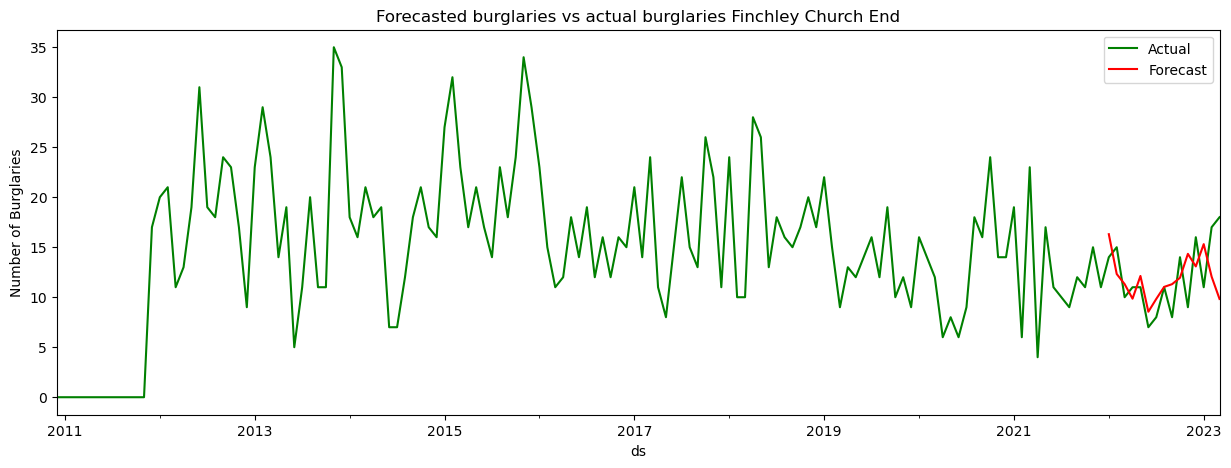

             ds       Date  year   y  Population per square kilometre  covid
1772 2010-12-01 2010-12-01  2010   0                              NaN      0
1773 2011-01-01 2011-01-01  2011   0                              NaN      0
1774 2011-02-01 2011-02-01  2011   0                              NaN      0
1775 2011-03-01 2011-03-01  2011   0                              NaN      0
1776 2011-04-01 2011-04-01  2011   0                              NaN      0
...         ...        ...   ...  ..                              ...    ...
1915 2022-11-01 2022-11-01  2022   8                              NaN      0
1916 2022-12-01 2022-12-01  2022   4                              NaN      0
1917 2023-01-01 2023-01-01  2023  16                              NaN      0
1918 2023-02-01 2023-02-01  2023   4                              NaN      0
1919 2023-03-01 2023-03-01  2023   9                              NaN      0

[148 rows x 6 columns]
nan
          Date         ds  year   y  Population 

17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing


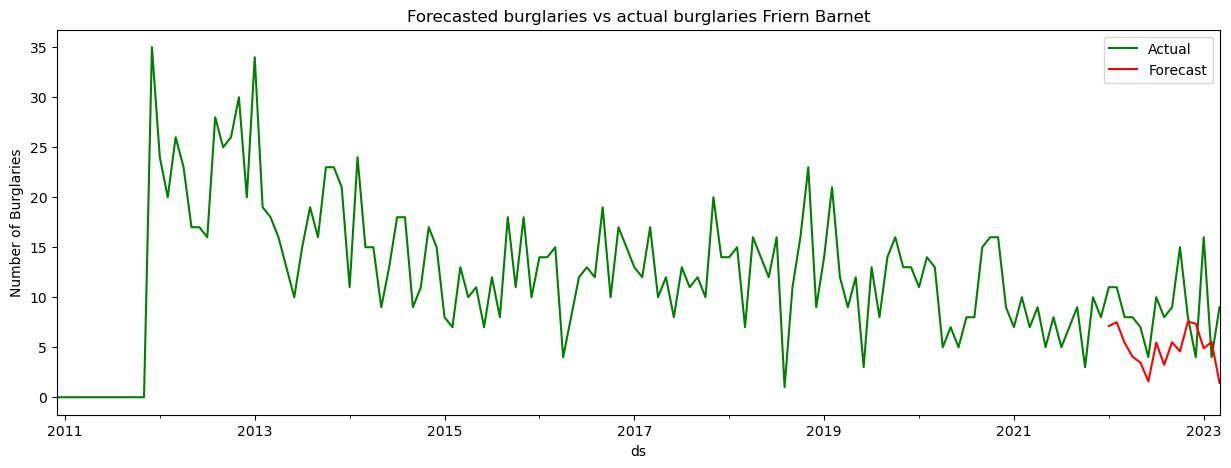

             ds       Date  year   y  Population per square kilometre  covid
1920 2010-12-01 2010-12-01  2010   0                              NaN      0
1921 2011-01-01 2011-01-01  2011   0                      3379.835130      0
1922 2011-02-01 2011-02-01  2011   0                      3379.835130      0
1923 2011-03-01 2011-03-01  2011   0                      3379.835130      0
1924 2011-04-01 2011-04-01  2011   0                      3379.835130      0
...         ...        ...   ...  ..                              ...    ...
2063 2022-11-01 2022-11-01  2022  12                      3557.598816      0
2064 2022-12-01 2022-12-01  2022   8                      3557.598816      0
2065 2023-01-01 2023-01-01  2023  10                      3546.818854      0
2066 2023-02-01 2023-02-01  2023   5                      3546.818854      0
2067 2023-03-01 2023-03-01  2023   9                      3546.818854      0

[148 rows x 6 columns]
3510.9978043214746
          Date         ds  year  

17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing


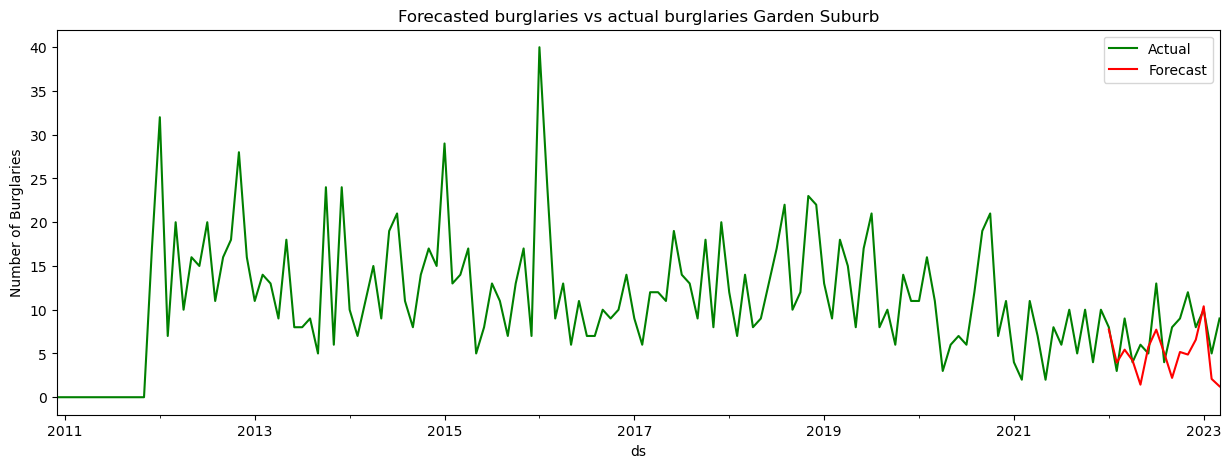

             ds       Date  year   y  Population per square kilometre  covid
2068 2010-12-01 2010-12-01  2010   0                              NaN      0
2069 2011-01-01 2011-01-01  2011   0                      6339.825386      0
2070 2011-02-01 2011-02-01  2011   0                      6339.825386      0
2071 2011-03-01 2011-03-01  2011   0                      6339.825386      0
2072 2011-04-01 2011-04-01  2011   0                      6339.825386      0
...         ...        ...   ...  ..                              ...    ...
2211 2022-11-01 2022-11-01  2022   8                      8054.063130      0
2212 2022-12-01 2022-12-01  2022   6                      8054.063130      0
2213 2023-01-01 2023-01-01  2023  11                      8309.267965      0
2214 2023-02-01 2023-02-01  2023   6                      8309.267965      0
2215 2023-03-01 2023-03-01  2023  12                      8309.267965      0

[148 rows x 6 columns]
7024.773509135015
          Date         ds  year   

17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing


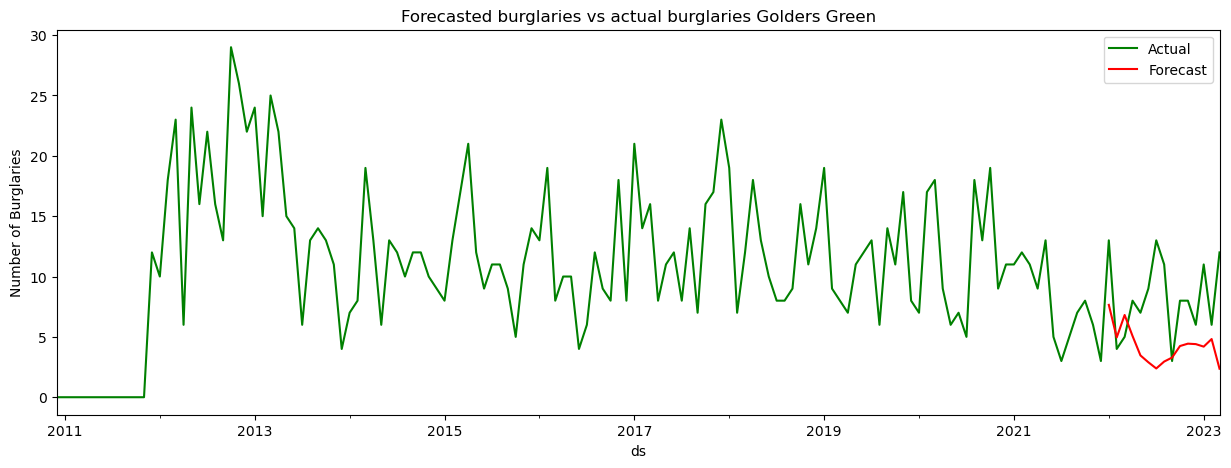

             ds       Date  year   y  Population per square kilometre  covid
2216 2010-12-01 2010-12-01  2010   0                              NaN      0
2217 2011-01-01 2011-01-01  2011   0                      6522.887324      0
2218 2011-02-01 2011-02-01  2011   0                      6522.887324      0
2219 2011-03-01 2011-03-01  2011   0                      6522.887324      0
2220 2011-04-01 2011-04-01  2011   0                      6522.887324      0
...         ...        ...   ...  ..                              ...    ...
2359 2022-11-01 2022-11-01  2022  18                      7098.239437      0
2360 2022-12-01 2022-12-01  2022  12                      7098.239437      0
2361 2023-01-01 2023-01-01  2023  15                      7063.732394      0
2362 2023-02-01 2023-02-01  2023  12                      7063.732394      0
2363 2023-03-01 2023-03-01  2023  14                      7063.732394      0

[148 rows x 6 columns]
6921.3064098878995
          Date         ds  year  

17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing


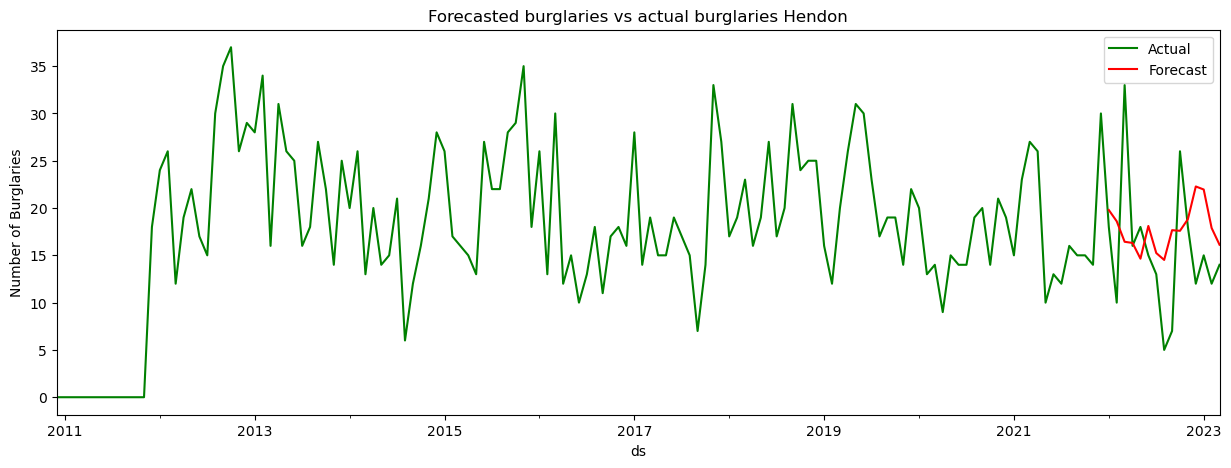

             ds       Date  year   y  Population per square kilometre  covid
2364 2010-12-01 2010-12-01  2010   0                              NaN      0
2365 2011-01-01 2011-01-01  2011   0                      1849.079312      0
2366 2011-02-01 2011-02-01  2011   0                      1849.079312      0
2367 2011-03-01 2011-03-01  2011   0                      1849.079312      0
2368 2011-04-01 2011-04-01  2011   0                      1849.079312      0
...         ...        ...   ...  ..                              ...    ...
2506 2022-10-01 2022-10-01  2022   7                      1933.325310      0
2507 2022-11-01 2022-11-01  2022  11                      1933.325310      0
2508 2023-01-01 2023-01-01  2023   9                      1932.723553      0
2509 2023-02-01 2023-02-01  2023   6                      1932.723553      0
2510 2023-03-01 2023-03-01  2023   7                      1932.723553      0

[147 rows x 6 columns]
1897.702112085097
          Date         ds    year 

17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing


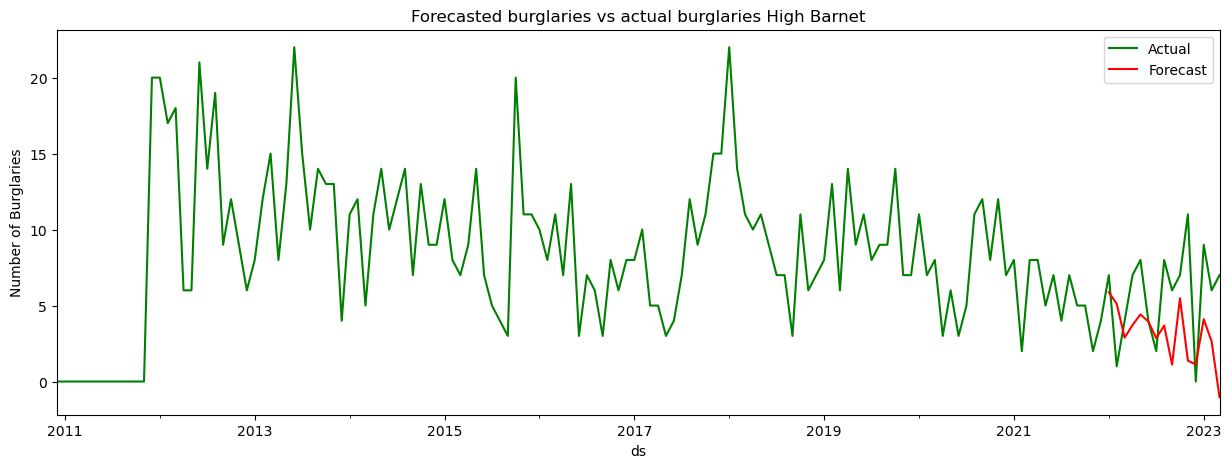

             ds       Date  year   y  Population per square kilometre  covid
2511 2010-12-01 2010-12-01  2010   0                              NaN      0
2512 2011-01-01 2011-01-01  2011   0                      1973.260893      0
2513 2011-02-01 2011-02-01  2011   0                      1973.260893      0
2514 2011-03-01 2011-03-01  2011   0                      1973.260893      0
2515 2011-04-01 2011-04-01  2011   0                      1973.260893      0
...         ...        ...   ...  ..                              ...    ...
2654 2022-11-01 2022-11-01  2022   8                      2728.560776      0
2655 2022-12-01 2022-12-01  2022  19                      2728.560776      0
2656 2023-01-01 2023-01-01  2023  16                      2854.799190      0
2657 2023-02-01 2023-02-01  2023  17                      2854.799190      0
2658 2023-03-01 2023-03-01  2023   7                      2854.799190      0

[148 rows x 6 columns]
2247.2372777810388
          Date         ds  year  

17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


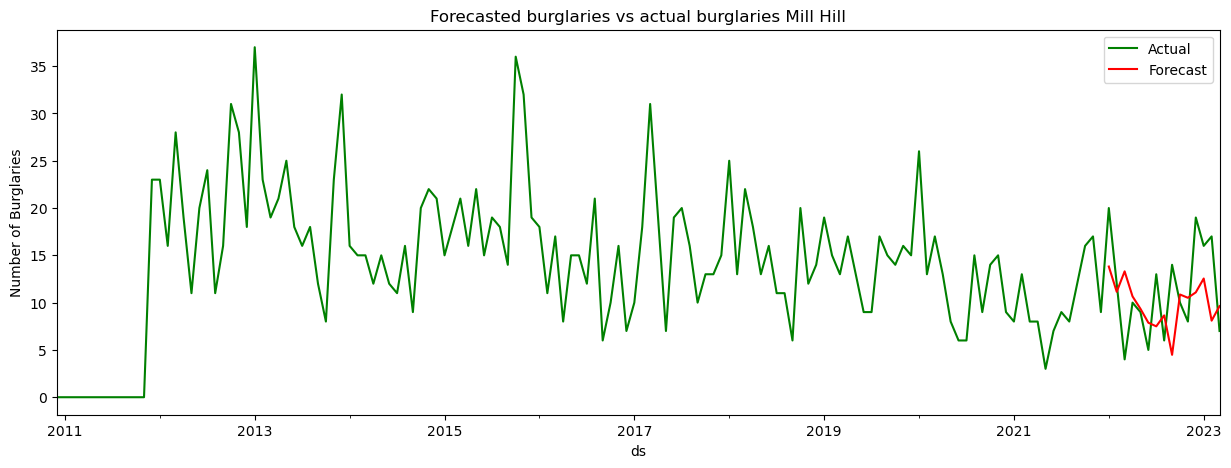

             ds       Date  year   y  Population per square kilometre  covid
2765 2010-12-01 2010-12-01  2010   0                              NaN      0
2766 2011-01-01 2011-01-01  2011   0                              NaN      0
2767 2011-02-01 2011-02-01  2011   0                              NaN      0
2768 2011-03-01 2011-03-01  2011   0                              NaN      0
2769 2011-04-01 2011-04-01  2011   0                              NaN      0
...         ...        ...   ...  ..                              ...    ...
2907 2022-11-01 2022-11-01  2022  17                              NaN      0
2908 2022-12-01 2022-12-01  2022  16                              NaN      0
2909 2023-01-01 2023-01-01  2023  13                              NaN      0
2910 2023-02-01 2023-02-01  2023  11                              NaN      0
2911 2023-03-01 2023-03-01  2023  12                              NaN      0

[147 rows x 6 columns]
nan
          Date         ds    year     y  Populat

17:48:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:08 - cmdstanpy - INFO - Chain [1] done processing


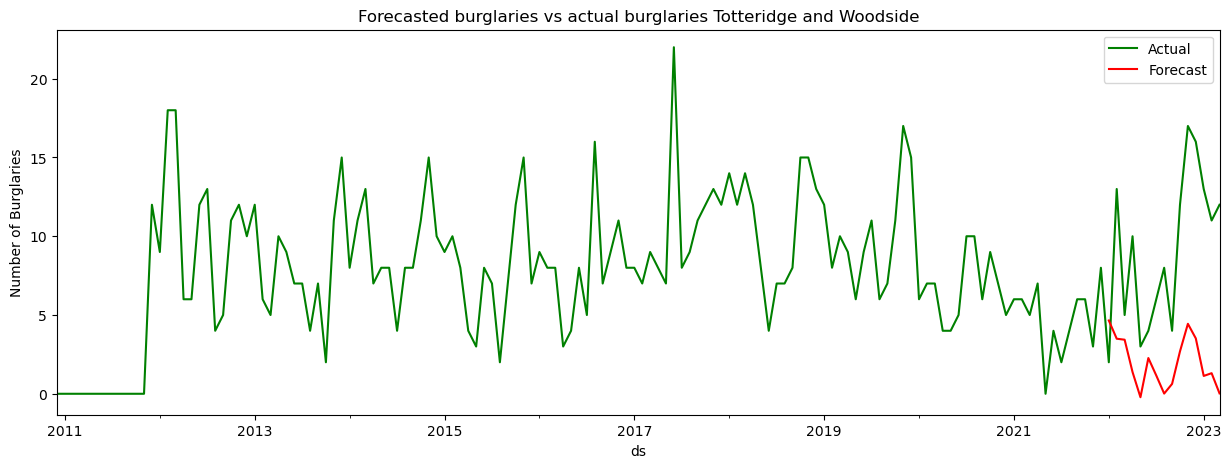

             ds       Date  year  y  Population per square kilometre  covid
2912 2010-12-01 2010-12-01  2010  0                              NaN      0
2913 2011-01-01 2011-01-01  2011  0                      3510.105448      0
2914 2011-02-01 2011-02-01  2011  0                      3510.105448      0
2915 2011-03-01 2011-03-01  2011  0                      3510.105448      0
2916 2011-04-01 2011-04-01  2011  0                      3510.105448      0
...         ...        ...   ... ..                              ...    ...
3055 2022-11-01 2022-11-01  2022  5                      3644.991213      0
3056 2022-12-01 2022-12-01  2022  5                      3644.991213      0
3057 2023-01-01 2023-01-01  2023  6                      3645.650264      0
3058 2023-02-01 2023-02-01  2023  3                      3645.650264      0
3059 2023-03-01 2023-03-01  2023  2                      3645.650264      0

[148 rows x 6 columns]
3593.4103870019007
          Date         ds  year  y  Populatio

17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing


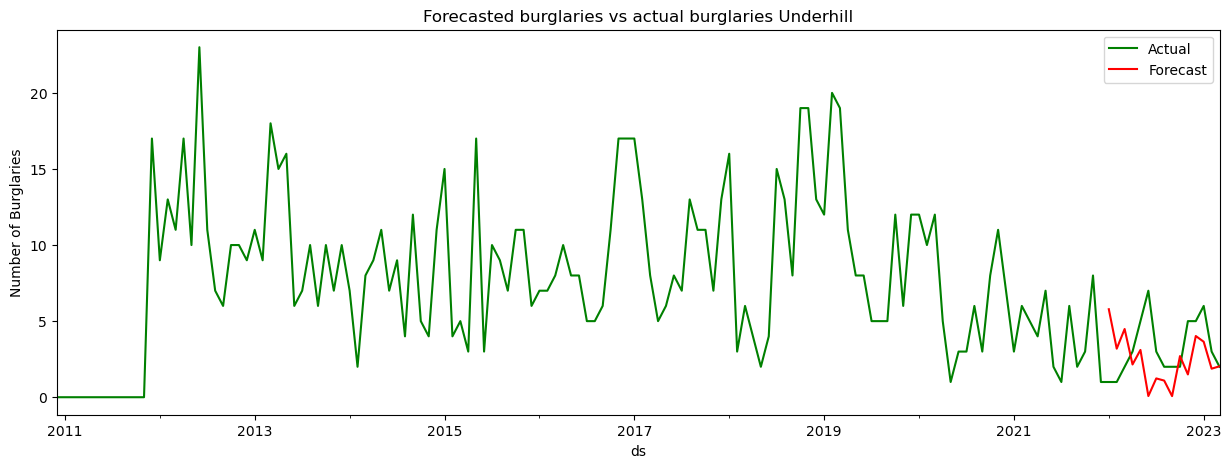

             ds       Date  year   y  Population per square kilometre  covid
3060 2010-12-01 2010-12-01  2010   0                              NaN      0
3061 2011-01-01 2011-01-01  2011   0                      7678.852383      0
3062 2011-02-01 2011-02-01  2011   0                      7678.852383      0
3063 2011-03-01 2011-03-01  2011   0                      7678.852383      0
3064 2011-04-01 2011-04-01  2011   0                      7678.852383      0
...         ...        ...   ...  ..                              ...    ...
3203 2022-11-01 2022-11-01  2022  13                      8234.150856      0
3204 2022-12-01 2022-12-01  2022   9                      8234.150856      0
3205 2023-01-01 2023-01-01  2023  17                      8210.550671      0
3206 2023-02-01 2023-02-01  2023   5                      8210.550671      0
3207 2023-03-01 2023-03-01  2023  13                      8210.550671      0

[148 rows x 6 columns]
8063.528789581541
          Date         ds  year   

17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing


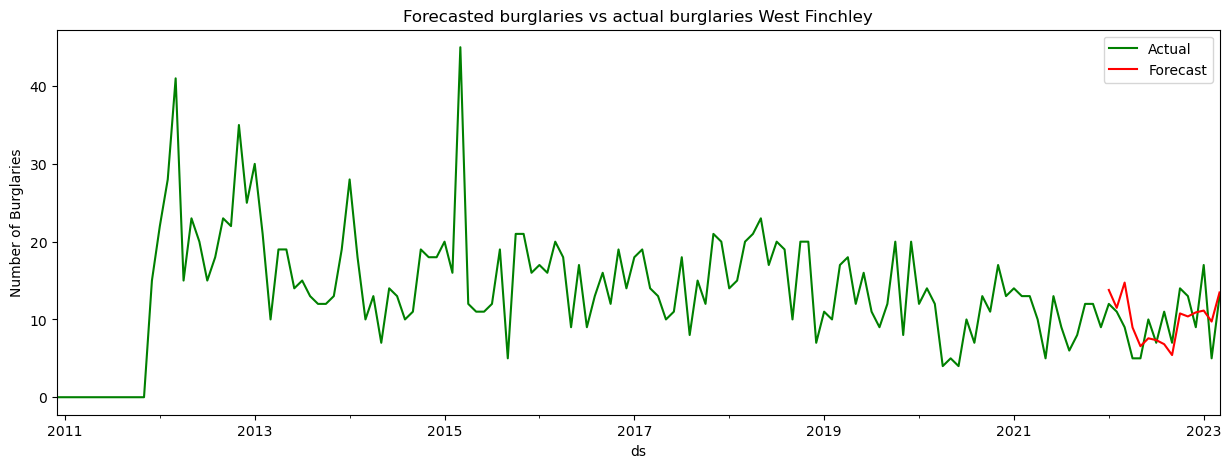

             ds       Date  year   y  Population per square kilometre  covid
3208 2010-12-01 2010-12-01  2010   0                              NaN      0
3209 2011-01-01 2011-01-01  2011   0                      5094.570928      0
3210 2011-02-01 2011-02-01  2011   0                      5094.570928      0
3211 2011-03-01 2011-03-01  2011   0                      5094.570928      0
3212 2011-04-01 2011-04-01  2011   0                      5094.570928      0
...         ...        ...   ...  ..                              ...    ...
3351 2022-11-01 2022-11-01  2022  10                      6206.946877      0
3352 2022-12-01 2022-12-01  2022   9                      6206.946877      0
3353 2023-01-01 2023-01-01  2023  11                      6242.848803      0
3354 2023-02-01 2023-02-01  2023   9                      6242.848803      0
3355 2023-03-01 2023-03-01  2023   8                      6242.848803      0

[148 rows x 6 columns]
5712.212730976804
          Date         ds  year   

17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing


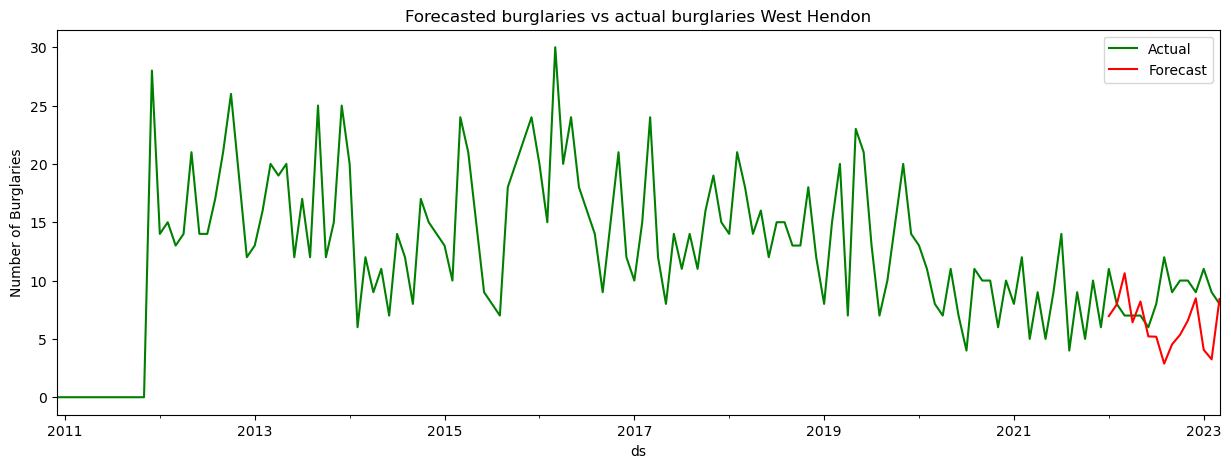

             ds       Date  year  y  Population per square kilometre  covid
3356 2010-12-01 2010-12-01  2010  0                              NaN      0
3357 2011-01-01 2011-01-01  2011  0                              NaN      0
3358 2011-02-01 2011-02-01  2011  0                              NaN      0
3359 2011-03-01 2011-03-01  2011  0                              NaN      0
3360 2011-04-01 2011-04-01  2011  0                              NaN      0
...         ...        ...   ... ..                              ...    ...
3499 2022-11-01 2022-11-01  2022  8                              NaN      0
3500 2022-12-01 2022-12-01  2022  9                              NaN      0
3501 2023-01-01 2023-01-01  2023  1                              NaN      0
3502 2023-02-01 2023-02-01  2023  3                              NaN      0
3503 2023-03-01 2023-03-01  2023  4                              NaN      0

[148 rows x 6 columns]
nan
          Date         ds  year  y  Population per square ki

17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing


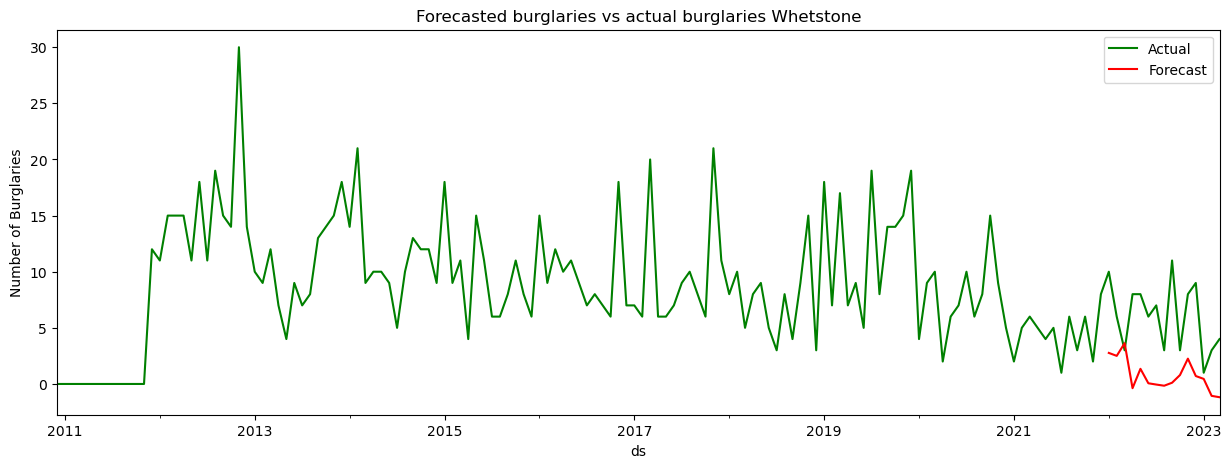

             ds       Date  year   y  Population per square kilometre  covid
3504 2010-12-01 2010-12-01  2010   0                              NaN      0
3505 2011-01-01 2011-01-01  2011   0                      6752.679939      0
3506 2011-02-01 2011-02-01  2011   0                      6752.679939      0
3507 2011-03-01 2011-03-01  2011   0                      6752.679939      0
3508 2011-04-01 2011-04-01  2011   0                      6752.679939      0
...         ...        ...   ...  ..                              ...    ...
3647 2022-11-01 2022-11-01  2022  15                      7214.395100      0
3648 2022-12-01 2022-12-01  2022   7                      7214.395100      0
3649 2023-01-01 2023-01-01  2023   5                      7205.589587      0
3650 2023-02-01 2023-02-01  2023   6                      7205.589587      0
3651 2023-03-01 2023-03-01  2023   8                      7205.589587      0

[148 rows x 6 columns]
7067.889177110354
          Date         ds  year   

17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing


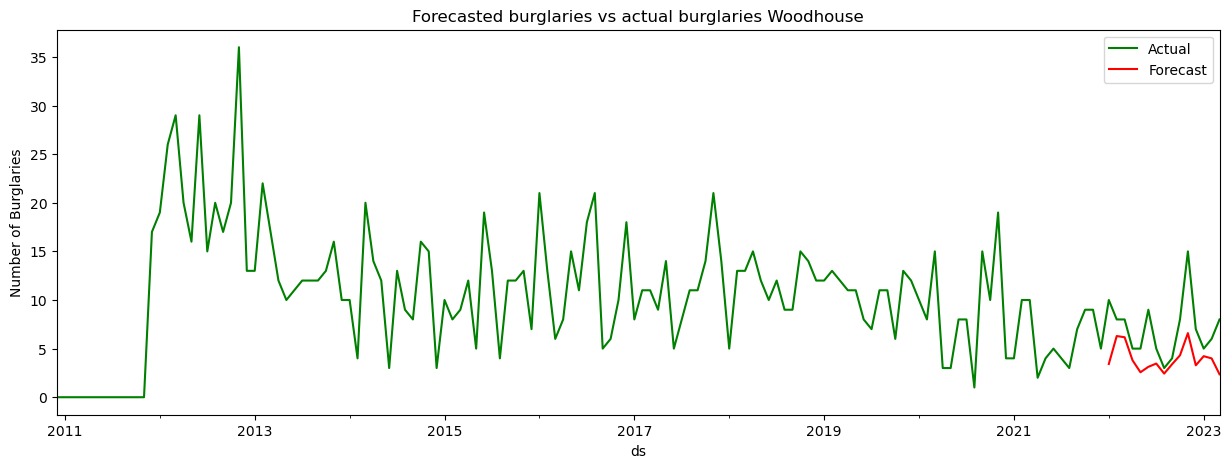

Mean MAE 3.7754246739603885
MAES [3.313792658124783, 2.4436378864345696, 4.428512733554888, 5.8802430419373755, 1.9182893418887943, 4.350555025521198, 3.3848711213785427, 2.390615138341949, 3.5530579920805794, 4.785827580217269, 1.6300694273290524, 2.867887982745135, 4.4719053886556175, 3.058960428693701, 4.411360121498422, 6.040644975404563, 3.459059739378875, 4.277712698323807, 7.425497132090004, 2.160830932984205, 2.7259530729877253, 3.2284243332778755, 5.297155307921019, 3.1053281142793687]
MSES [18.27935593365601, 9.83566326068767, 28.596372253437618, 57.092601166394175, 7.940564715204445, 27.335041848371002, 17.690328702303987, 8.046585311202673, 19.819798642027887, 33.810920101271485, 4.018775441205087, 12.29771103697506, 28.442781934844, 15.590677148570501, 29.24386905918073, 56.42275823722641, 18.824374837830774, 28.672311457849776, 70.96776138154216, 7.615823544672791, 10.555989158225163, 17.207249854926086, 36.208641974782566, 15.270562476462214]
r2 [-3.7602489410562523, 0.1

In [103]:
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury','Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon','High Barnet', 'Mill Hill', 'Totteridge and Woodside', 'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']
mse = []
mae = []
r2 = []

print(len(wards))
for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre','covid']]
       print(df_ward)
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       mean_population = df_ward['Population per square kilometre'].mean()
       print(mean_population)
       df_ward['Population per square kilometre'].fillna(mean_population, inplace=True)
       df_ward['covid'].fillna(0, inplace=True)
       print(df_ward)
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       print(train_ward[train_ward['covid'].isnull()])
       best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 10, seasonality_prior_scale= 30, holidays_prior_scale= 30, holidays= holiday)
       if not math.isnan(mean_population):
              best_model.add_regressor('Population per square kilometre')
       best_model.add_regressor('covid')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates[-forecast_upto:])
       mae.append(mean_absolute_error(test_ward['y'], forecast['yhat']))
       mse.append(mean_squared_error(test_ward['y'], forecast['yhat']))
       r2.append(r2_score(test_ward['y'], forecast['yhat']))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       ax.set_xlabel("Year")
       ax.set_ylabel("Number of Burglaries")
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       title = 'Forecasted burglaries vs actual burglaries ' + ward
       plt.title(title)
       plt.show()


print("Mean MAE", np.mean(mae))
print("MAES", mae)
print("MSES", mse)
print("r2", r2)